In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# Step 1: Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # Assuming input image size of 224x224
        self.fc2 = nn.Linear(128, 2)  # 2 output classes: Leak and Non-Leak
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 + ReLU + MaxPool
        
        x = x.view(-1, 64 * 28 * 28)  # Flatten the tensor
        x = self.relu(self.fc1(x))  # Fully connected layer 1 + ReLU
        x = self.dropout(x)
        x = self.fc2(x)  # Fully connected layer 2 (Output layer)
        
        return x

# Step 2: Define data transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Step 3: Manually Load and Split the Dataset
# Your dataset paths
leak_dir = 'E:/Pipeline Dataset/Pipeline Dataset/CWT RGB/CWT Gas_13Bar/Leak/channel1'
non_leak_dir = 'E:/Pipeline Dataset/Pipeline Dataset/CWT RGB/CWT Gas_13Bar/Non Leak/channel1'

# Load all image paths for both classes
leak_image_paths = [os.path.join(leak_dir, img) for img in os.listdir(leak_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
non_leak_image_paths = [os.path.join(non_leak_dir, img) for img in os.listdir(non_leak_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Combine both lists and create labels (1 for Leak, 0 for Non-Leak)
all_image_paths = leak_image_paths + non_leak_image_paths
labels = [1] * len(leak_image_paths) + [0] * len(non_leak_image_paths)

# Define a custom dataset loader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create the dataset object
dataset = CustomDataset(all_image_paths, labels, transform=transform)

# Split the dataset into training and testing sets (80% train, 20% test)
train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=labels)

# Create subsets for training and testing
train_subset = Subset(dataset, train_idx)
test_subset = Subset(dataset, test_idx)

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Step 4: Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Step 5: Training function
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Track training loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Average training loss and accuracy for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()  # Set to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        # Average validation loss and accuracy for the epoch
        epoch_val_loss = val_loss / len(test_loader)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print progress for the current epoch
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Step 6: Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, test_loader, num_epochs=8)

# Step 7: Plot learning curves for loss and accuracy
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Learning Curve (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to get predictions and true labels from the test loader
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and append
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and append
    
    return all_preds, all_labels

# Get predictions and true labels
y_pred, y_true = get_predictions_and_labels(model, test_loader)

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", 
            annot_kws={"weight": "bold", "size": 12}, cbar=False)

# Modify the tick labels to display "Non Leak" and "Leak"
plt.xticks(ticks=[0.5, 1.5], labels=["Non Leak", "Leak"])
plt.yticks(ticks=[0.5, 1.5], labels=["Non Leak", "Leak"])

# Add labels for axes
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()


In [4]:
# Function to get predictions and true labels from the test set
def get_predictions(model, dataloader):
    model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class with the max score
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels
    
    return all_preds, all_labels


In [6]:
from sklearn.manifold import TSNE
import numpy as np
import torch

# Function to extract features from the fully connected layer before classification
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels_list = []
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Extract features from the layer before the output layer (fc1)
            x = model.pool(model.relu(model.conv3(model.pool(model.relu(model.conv2(model.pool(model.relu(model.conv1(inputs)))))))))
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = model.relu(model.fc1(x))  # Get features from the penultimate layer
            features.append(x.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.concatenate(features), np.concatenate(labels_list)

# Extract features and labels from the test set
features, labels = extract_features(model, test_loader)


In [7]:
# Apply t-SNE to reduce the feature vectors to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming features and labels are already extracted as in your code

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Define custom colors for Non-Leak and Leak
colors = ['purple', 'yellow']

# Plot t-SNE results with improved visualization
plt.figure(figsize=(6, 5))

# Plot Non-Leak data points (label 0)
plt.scatter(tsne_results[labels == 0, 0], 
            tsne_results[labels == 0, 1], 
            label='Non-Leak', 
            color=colors[0], 
            s=60,  # Increase marker size
            edgecolor='k',  # Add black edges to points
            alpha=0.8)

# Plot Leak data points (label 1)
plt.scatter(tsne_results[labels == 1, 0], 
            tsne_results[labels == 1, 1], 
            label='Leak', 
            color=colors[1], 
            s=60,  # Increase marker size
            edgecolor='k',  # Add black edges to points
            alpha=0.8)

# Add title and labels


# Add a legend to indicate which class corresponds to which color
plt.legend()

# Display the plot
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get predictions and true labels from the test set
y_pred, y_true = get_predictions(model, test_loader)

# Print the classification report
report = classification_report(y_true, y_pred, target_names=['Non-Leak', 'Leak'])
print(report)


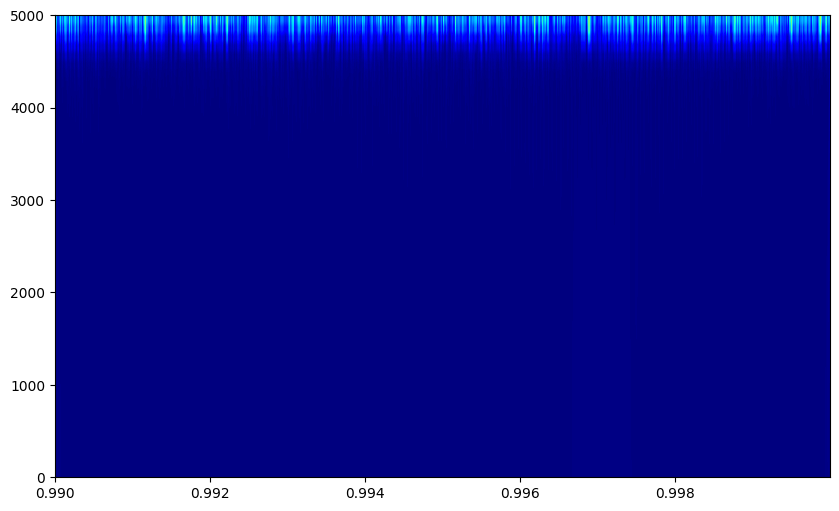

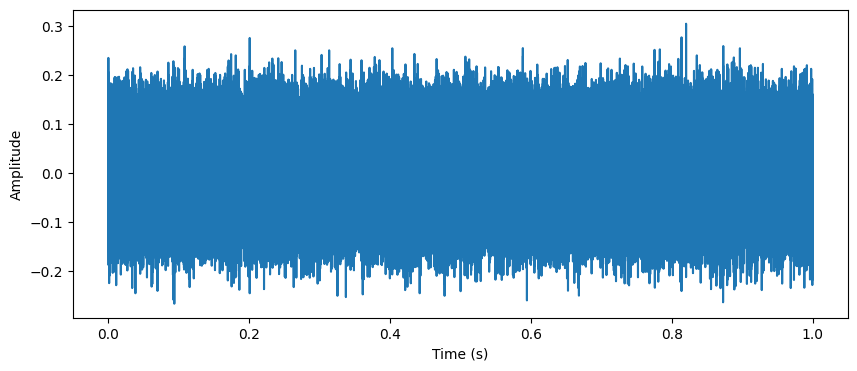

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift

def stockwell_transform_chunked(signal, fs, fmin, fmax, chunk_size=10000):
    """
    Compute the Stockwell Transform (S-transform) of the signal in chunks to avoid memory overflow.
    
    Parameters:
    signal : array-like
        Input signal to be transformed.
    fs : float
        Sampling frequency of the signal.
    fmin : float
        Minimum frequency for the transform.
    fmax : float
        Maximum frequency for the transform.
    chunk_size : int
        The number of time points to process at a time.
    
    Returns:
    freqs : 1D array
        Frequencies corresponding to the rows of the scalogram.
    times : 1D array
        Time corresponding to the columns of the scalogram.
    """
    N = len(signal)
    t = np.arange(N) / fs  # Time vector
    freqs = np.fft.fftfreq(chunk_size, d=1/fs)  # Frequency vector for chunk

    # Restrict the frequency range
    freqs = freqs[(freqs >= fmin) & (freqs <= fmax)]
    
    # Initialize figure for real-time plotting
    plt.figure(figsize=(10, 6))
    
    # Process the signal in chunks
    for start_idx in range(0, N, chunk_size):
        end_idx = min(start_idx + chunk_size, N)
        signal_chunk = signal[start_idx:end_idx]
        
        # Create time vector for this chunk
        t_chunk = t[start_idx:end_idx]
        
        # Preallocate the S-transform matrix for the chunk
        st_matrix_chunk = np.zeros((len(freqs), len(signal_chunk)), dtype=complex)
        
        # Perform FFT of the signal chunk
        signal_fft_chunk = fft(signal_chunk, n=chunk_size)
        
        # Loop through each frequency for the chunk
        for idx, f in enumerate(freqs):
            # Gaussian window width based on frequency
            width = 1 / (2 * np.pi * abs(f + np.finfo(float).eps))
            
            # Create Gaussian window
            gaussian_window = np.exp(-(t_chunk - t_chunk[len(t_chunk) // 2])**2 / (2 * width**2))
            
            # Perform inverse FFT of the windowed Fourier coefficients
            st_matrix_chunk[idx, :] = ifft(signal_fft_chunk[:len(signal_chunk)] * fftshift(gaussian_window), len(signal_chunk))
        
        # Normalize the magnitude
        st_matrix_chunk = np.abs(st_matrix_chunk)
        st_matrix_chunk /= np.max(st_matrix_chunk)  # Normalize to the maximum value
        
        # Apply logarithmic scaling for better visibility
        plt.imshow(np.log1p(st_matrix_chunk), aspect='auto', extent=[t_chunk.min(), t_chunk.max(), freqs.min(), freqs.max()], cmap='jet')
    
    # Add colorbar and labels to the plot

    plt.show()

def load_dat_file(file_path, dtype=np.float64):
    """
    Load a .dat file and return the signal data.
    
    Parameters:
    file_path : str
        Path to the .dat file.
    dtype : data-type
        The data type of the file contents (default is np.float64).
    
    Returns:
    data : array-like
        Loaded data from the .dat file.
    """
    data = np.fromfile(file_path, dtype=dtype)
    return data

# Test the Stockwell Transform function
if __name__ == "__main__":
    # Load the .dat file
    file_path = 'E:/Pipeline Dataset/Pipeline Dataset/2022 training data/Gas_13Bar/220seconds/channel1.dat'  # Adjust the path
    data = load_dat_file(file_path, dtype=np.float64)  # Adjust dtype if necessary
    
    # Define the sampling frequency (replace with the actual value)
    fs = 1000000  # Example: 1 MHz sampling rate, adjust based on your dataset
    
    # Set frequency range for S-transform
    fmin = 0  # Minimum frequency (e.g., 0 Hz)
    fmax = 5000  # Maximum frequency (adjust based on your needs)
    
    # Apply the Stockwell Transform with chunking
    stockwell_transform_chunked(data, fs, fmin, fmax, chunk_size=10000)
    
    # Plot the raw signal for inspection
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(data)) / fs, data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()


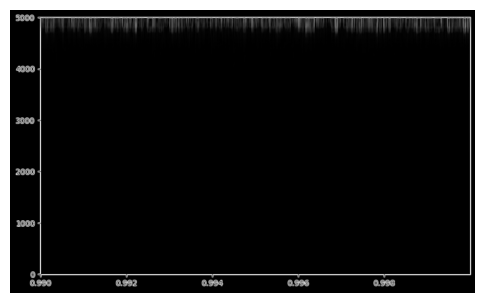

In [23]:
import cv2  # OpenCV library
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r'E:\Conference Paper\Results\leak_s_transform.png'  # Adjust the path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Apply Sobel edge detection
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Sobel filter in X direction
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Sobel filter in Y direction

# Compute the magnitude of gradients (edges)
sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)

# Normalize the image for better visualization
sobel_combined = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX)

# Display the original and Sobel-filtered images
plt.figure(figsize=(6, 5))

plt.imshow(sobel_combined, cmap='gray')
plt.axis('off')

plt.show()


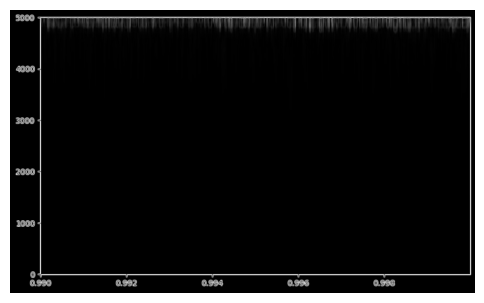

In [24]:
import cv2  # OpenCV library
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r'E:\Conference Paper\Results\s_transform_nonLeak.png'  # Adjust the path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Apply Sobel edge detection
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Sobel filter in X direction
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Sobel filter in Y direction

# Compute the magnitude of gradients (edges)
sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)

# Normalize the image for better visualization
sobel_combined = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX)

# Display the original and Sobel-filtered images
plt.figure(figsize=(6, 5))

plt.imshow(sobel_combined, cmap='gray')
plt.axis('off')

plt.show()
